## 0. Setups

In [ ]:
from google.colab import drive
drive.mount('/content/drive/blood-vessel-segmentation')

In [ ]:
# system and misc
import os
import time
import sys

# data manipulation and visualization
import numpy as np
import pandas
import matplotlib.pyplot as plt

# image processing
from skimage import io, transform, exposure
import albumentations as Alb
#import tifffile

# deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, random_split
#import pretrainedmodels as ptm # pip install pretrainedmodels

## 1. Configuration

In [ ]:
class CFG:
    """
    Configuration class for the blood vessel segmentation project.
    """

    # ============== Model Configuration =============
    MODEL_NAME = 'Unet'
    IN_CHANNEL = 1  # Number of input channels (e.g., 1 for grayscale images)
    OUT_CHANNEL = 1 # Number of output channels

    # ============== Image Processing Settings =============
    INPUT_IMAGE_SIZE = (1024, 1024)  # Size of the input images (height x width)
    GAMMA = 1

    # =============
    # = Training and Validation Parameters =============
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    VALID_ID = 1  # ID for validation dataset or fold
    BATCH_SIZE = 1  # Batch size for model training
    THRESHOLD_PERCENTILE = 0.0014109  # Threshold for post-processing
    LEARNING_RATE = 1e-4
    NUM_EPOCHS = 50
    NUM_WORKERS = 0 # Number of threds
    TRAIN_TEST_SPLIT_RATIO = 0.2 # for test subset

    # ============== Model Paths =============
    # List of paths to trained model weights
    MODEL_PATHS = [
        "/path/to/model1.pt",
        "/path/to/model2.pt",
        # Add more model paths as needed
    ]

    # ============== Data Paths =============
    DATASET_NAME = "kidney_1_dense"
    DATASET_DIRECTORY = os.path.join(".", "blood-vessel-segmentation")
    TRAIN_DATASET_DIRECTORY = os.path.join(DATASET_DIRECTORY, "train", DATASET_NAME)
    TEST_DATASET_DIRECTORY = os.path.join(DATASET_DIRECTORY, "test", DATASET_NAME)

## 2. Load Dataset

### 2,1 Custom Dataset Class

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_path, mask_path=None, target_image_size=(512, 512), convert_size=True, gamma=1, image_format=".tif"):
        # File IO
        self.image_path = image_path
        self.image_format = image_format
        self.image_filenames = sorted([os.path.join(image_path, filename) for filename in os.listdir(image_path) if filename.endswith(self.image_format)])
        print(f"{len(self.image_filenames)} samples are loaded.")

        # If masks (labels) are given
        self.mask_path = mask_path
        if self.mask_path:
            self.mask_filenames = sorted([os.path.join(self.mask_path, filename) for filename in os.listdir(self.mask_path) if filename.endswith(self.image_format)])
            if not len(self.mask_filenames) == len(self.image_filenames):
                raise(f"Number of images and labels are not matched: {len(self.image_filenames)} images and {len(self.mask_filenames)} labels.")
            print(f"{len(self.mask_filenames)} labels are loaded.")

        # Image processing
        self.target_image_size = target_image_size
        self.convert_size = convert_size
        self.gamma = gamma

        # Process and print the size of the first image if convert_size is True
        if self.convert_size and len(self.image_filenames) > 0:
            first_image = io.imread(self.image_filenames[0])
            resized_image = self.resize_and_pad(first_image, self.target_image_size)
            print(f"Original size: {first_image.shape}, Converted size: {resized_image.shape}")

    def __getitem__(self, index):
        # Load image
        image = io.imread(self.image_filenames[index])

        # Resize and pad the image if convert_size is True
        if self.convert_size:
            image = self.resize_and_pad(image, self.target_image_size)

        # Extract the filename
        image_filename = os.path.basename(self.image_filenames[index])

        # If masks (labels) are given
        if self.mask_path:
            mask = io.imread(self.mask_filenames[index])
            mask = self.resize_and_pad(mask, self.target_image_size, gamma=1) # mask containing 0s and 1s only.
            return image, mask, image_filename

        return image, image_filename

    def __len__(self):
        return len(self.image_filenames)

    def resize_and_pad(self, image, target_image_size, gamma=3):
        """Resize an image, apply gamma correction, and add padding to keep aspect ratio."""
        # Calculate scale and padding
        h, w = image.shape[:2]
        scale = min(target_image_size[0] / h, target_image_size[1] / w)
        new_h, new_w = int(h * scale), int(w * scale)
        pad_h = (target_image_size[0] - new_h) // 2
        pad_w = (target_image_size[1] - new_w) // 2

        # Resize image with 'constant' mode to keep original pixel values
        image_resized = transform.resize(
            image,
            (new_h, new_w),
            mode='constant',
            anti_aliasing=True,
            preserve_range = True, # preserve the original image's intensity range
            order=1
        )

        # Apply gamma correction to adjust brightness
        if not self.gamma == 1:
            image_resized = exposure.adjust_gamma(image_resized, gamma)

        # Add a channel dimension to grayscale images if necessary
        if len(image.shape) == 2:  # Grayscale image
            image_resized = image_resized[..., np.newaxis]

        # Initialize padded image
        padded_image = np.zeros((target_image_size[0], target_image_size[1], image_resized.shape[2]), dtype=image_resized.dtype)

        # Insert the resized and adjusted image into the padded image
        padded_image[pad_h:pad_h+new_h, pad_w:pad_w+new_w, :] = image_resized

        return padded_image

### 2.2 Display Function

In [ ]:
def display_image(images, titles=None, max_cols=4):
    # Wrap single image in a list
    if not isinstance(images, list):
        images = [images]
        titles = [titles] if titles is not None else titles

    if titles is not None and not isinstance(titles, list):
        raise TypeError("Titles should be provided as a list or a single title for a single image.")

    if titles and len(images) != len(titles):
        raise ValueError("Every image should have a corresponding title.")

    num_images = len(images)
    cols = min(num_images, max_cols)
    rows = num_images // cols + (num_images % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    if rows == 1 or cols == 1:
        axes = np.array([axes])

    axes = axes.flatten()[:num_images]  # Limit to the number of images to avoid blank subplots

    for ax, img, title in zip(axes, images, titles or [None]*num_images):
        if isinstance(img, torch.Tensor):
            img = img.cpu().numpy()
            if img.ndim == 3 and img.shape[0] in [1, 3, 4]:
                img = img.transpose(1, 2, 0)
            if img.ndim == 3 and img.shape[2] == 1:
                img = img.squeeze(2)

        ax.imshow(img, cmap='gray')
        if title:
            ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

### 2.3 Load Dataset and Display Sample Image

In [ ]:
image_path = os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "images")
mask_path = os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "labels")
dataset = CustomDataset(image_path, mask_path, target_image_size=CFG.INPUT_IMAGE_SIZE, gamma=CFG.GAMMA)


2279 samples are loaded.
2279 labels are loaded.
Original size: (1303, 912), Converted size: (1024, 1024, 1)


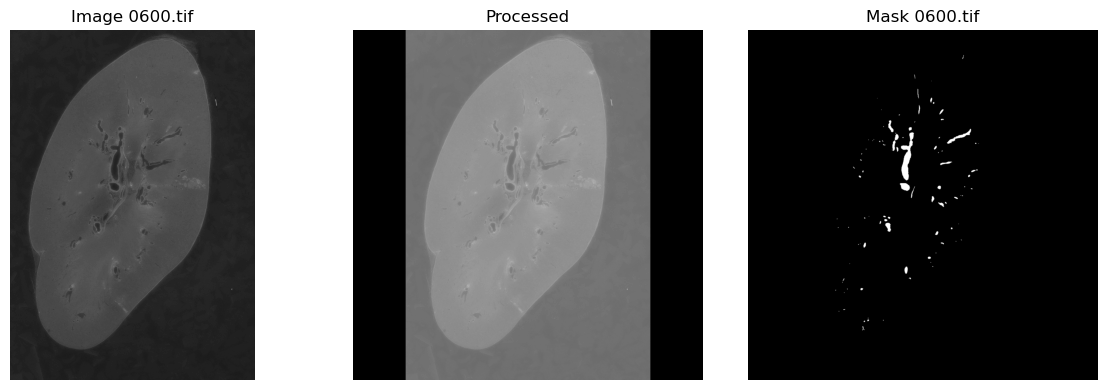

In [ ]:
index = 600
original_image = io.imread(os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "images", dataset[index][2]))
display_image([original_image, dataset[index][0], dataset[index][1]], [f"Image {dataset[index][2]}", "Processed", f"Mask {dataset[index][2]}"])

### 2.4 Train-Test-Split and DataLoader

In [ ]:
# Calculate the sizes of train and test sets
total_size = len(dataset)
test_size = int(total_size * CFG.TRAIN_TEST_SPLIT_RATIO)
train_size = total_size - test_size

# Split the dataset into train and test datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Further split the train dataset into train and validation datasets
val_size = int(train_size * CFG.TRAIN_TEST_SPLIT_RATIO)
new_train_size = train_size - val_size
train_dataset, val_dataset = random_split(train_dataset, [new_train_size, val_size])

# Create DataLoaders for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=CFG.NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)

## 3. Image Augmentation

In [ ]:
def Augement_image(image, mask):

    image_dense = torch.from_numpy(image.astype(np.float32))
    mask_dense = torch.from_numpy(mask.astype(np.float32))

    if len(image_dense.shape) == 2:
        image_dense = image_dense.unsqueeze(0)

    image_np = image_dense.permute(1, 2, 0).numpy()
    mask_np = mask_dense.numpy()

    image_list = [None, None, None, None]
    mask_list = [None, None, None, None]

    transform_rotate_90 = Alb.Compose([
        Alb.Rotate(limit=90, p=0.5)
    ])

    # Original image
    image_list[0] = image_np
    mask_list[0] = mask_np

    # Original image with 90-degree rotation
    augmented_rotate_90 = transform_rotate_90(image=image_np, mask=mask_np)
    image_list[1], mask_list[1] = augmented_rotate_90['image'], augmented_rotate_90['mask']

    # Original image with 180-degree rotation
    augmented_rotate_180 = transform_rotate_90(image=image_list[1], mask=mask_list[1])
    image_list[2], mask_list[2] = augmented_rotate_180['image'], augmented_rotate_180['mask']

    # Original image with 270-degree rotation
    augmented_rotate_270 = transform_rotate_90(image=image_list[2], mask=mask_list[2])
    image_list[3], mask_list[3] = augmented_rotate_270['image'], augmented_rotate_270['mask']

    # Making the mask dimentions 3
    for i in range(4):
        if mask_list[i].ndim == 2:
            mask_list[i] = mask_list[i][..., np.newaxis]

    augmented_data_zip = list(zip(*[image_list, mask_list]))

    return augmented_data_zip

![image.png](attachment:image.png)

## 4. Model

In [ ]:
# SSL certificate expired for se_resnext50_32x4d encoder
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### 4.1 Attention U-Net ResNext50 32x4d

In [ ]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x):
        s = self.conv(x)
        p = self.pool(s)
        return s, p

class attention_gate(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.Wg = nn.Sequential(
            nn.Conv2d(in_c[0], out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.Ws = nn.Sequential(
            nn.Conv2d(in_c[1], out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.ReLU(inplace=True)
        self.output = nn.Sequential(
            nn.Conv2d(out_c, out_c, kernel_size=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, g, s):
        Wg = self.Wg(g)
        Ws = self.Ws(s)
        out = self.relu(Wg + Ws)
        out = self.output(out)
        return out * s

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.ag = attention_gate(in_c, out_c)
        self.c1 = conv_block(in_c[0]+out_c, out_c)

    def forward(self, x, s):
        x = self.up(x)
        s = self.ag(x, s)
        x = torch.cat([x, s], axis=1)
        x = self.c1(x)
        return x

class attention_unet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder_block(1, 64)  # Adjusted for 1 input channel
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        # Add more encoder blocks if needed to accommodate the larger input size

        self.b1 = conv_block(256, 512)

        self.d1 = decoder_block([512, 256], 256)
        self.d2 = decoder_block([256, 128], 128)
        self.d3 = decoder_block([128, 64], 64)
        # Add more decoder blocks symmetrically if more encoder blocks are added

        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)  # Output for 1 channel

    def forward(self, x):
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)

        b1 = self.b1(p3)

        d1 = self.d1(b1, s3)
        d2 = self.d2(d1, s2)
        d3 = self.d3(d2, s1)

        output = self.output(d3)
        return output

### 4.2 Model Summary

In [ ]:
model = attention_unet()
# summary(model, input_size = (CFG.BATCH_SIZE, 1, CFG.INPUT_IMAGE_SIZE[0], CFG.INPUT_IMAGE_SIZE[1]))
summary(model, input_size = (1, 1, CFG.INPUT_IMAGE_SIZE[0], CFG.INPUT_IMAGE_SIZE[1]))

Layer (type:depth-idx)                   Output Shape              Param #
attention_unet                           [1, 1, 1024, 1024]        --
├─encoder_block: 1-1                     [1, 64, 1024, 1024]       --
│    └─conv_block: 2-1                   [1, 64, 1024, 1024]       --
│    │    └─Sequential: 3-1              [1, 64, 1024, 1024]       37,824
│    └─MaxPool2d: 2-2                    [1, 64, 512, 512]         --
├─encoder_block: 1-2                     [1, 128, 512, 512]        --
│    └─conv_block: 2-3                   [1, 128, 512, 512]        --
│    │    └─Sequential: 3-2              [1, 128, 512, 512]        221,952
│    └─MaxPool2d: 2-4                    [1, 128, 256, 256]        --
├─encoder_block: 1-3                     [1, 256, 256, 256]        --
│    └─conv_block: 2-5                   [1, 256, 256, 256]        --
│    │    └─Sequential: 3-3              [1, 256, 256, 256]        886,272
│    └─MaxPool2d: 2-6                    [1, 256, 128, 128]        --
├

## 5. Evaluation

In [ ]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

### 5.1 Run-Length Encode and Decode

Run-Length Encoding (RLE) is a simple form of data compression where runs of data (i.e., sequences in which the same data value occurs in many consecutive data elements) are stored as a single data value and count. It is particularly effective for data with many such runs, as it can significantly reduce the size of the data.

In the context of image segmentation, such as in a Kaggle competition for blood vessel segmentation from CT images, RLE is often used to encode binary masks. In a binary mask, each pixel is either part of the object of interest (e.g., a blood vessel) or the background. RLE can efficiently represent these masks, especially when large regions of pixels are the same (all vessel or all background).

The encoding typically works as follows:

1. The binary mask is flattened into a one-dimensional array (e.g., by taking each row of pixels in turn).
2. The algorithm goes through this array and counts the number of consecutive pixels with the same value.
3. Each run of pixels is then represented by two numbers: the start position in the flattened array and the length of the run.

For example, the array <code>[0, 0, 1, 1, 1, 0, 0]</code> would be encoded as <code>[2, 3]</code> in RLE, meaning that starting from the third element, there are three consecutive 1s.

### 5.2 Loss Functions

#### 5.2.1. DICE Loss
Dice loss is particularly useful for data with imbalanced classes. It measures the overlap between the predicted segmentation and the ground truth.

In [ ]:
class DiceLoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.sigmoid()
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        return 1 - dice

#### 5.2.2. Jaccard/Intersection over Union (IoU) Loss
Similar to Dice loss, IoU is another common metric for the evaluation of object detection algorithms, such as image segmentation.

In [ ]:
class IoULoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.sigmoid()
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection
        IoU = (intersection + smooth) / (union + smooth)
        return 1 - IoU

#### 5.2.3 Focal Loss
This loss function is designed to address class imbalance by down-weighting well-classified examples.

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

### 5.4 Metrics

In [ ]:
def calculate_metrics(y_pred, y_true):
    """
    Calculates IOU, F1 score, precision, recall, and accuracy for U-Net predictions using NumPy.

    Arguments:
    y_true -- the ground truth labels (a binary array of 0s and 1s)
    y_pred -- the predicted labels (a binary array of 0s and 1s)

    Returns:
    A dictionary containing the IOU, F1 score, precision, recall, and accuracy.
    """
    with torch.no_grad():
        # Convert probability output to binary predictions
        y_pred = (y_pred > 0.5).float()

        # Flatten the arrays
        y_true = y_true.detach().cpu().numpy().flatten()
        y_pred = y_pred.detach().cpu().numpy().flatten()

        # Calculate true positives, false positives, and false negatives
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))

        # Very small number to prevent infinity when dividing zero
        eps = 1e-8

        # Calculate IOU
        iou = tp / (tp + fp + fn + eps)

        # Calculate precision
        precision = tp / (tp + fp + eps)

        # Calculate recall
        recall = tp / (tp + fn + eps)

        # Calculate F1 score
        f1_score = 2 * (precision * recall) / (precision + recall + eps)

        # Calculate accuracy
        accuracy = np.sum(y_true == y_pred) / len(y_true)

    # Return a dictionary containing the metrics
    metrics = {"IoU_Score": iou, "F1_Score": f1_score, "Precision": precision, "Recall": recall, "Accuracy": accuracy}
    return metrics

## 6. Train

### 6.1 Trainer Class

In [ ]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, optimizer, criterion, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device

    def train_epoch(self):
        self.model.train()
        for batch_index, batch in enumerate(tqdm(self.train_loader)):
            self.optimizer.zero_grad()
            data, target, filename = batch

            data = data.to(self.device, dtype=torch.float32).permute(0, 3, 1, 2)
            target = target.to(self.device, dtype=torch.float32).permute(0, 3, 1, 2)

            # Convert data and target to float
            data = data.float()
            target = target.float()

            output = self.model(data)
            train_loss = self.criterion(output, target)
            train_loss.backward()
            self.optimizer.step()

            train_loss += train_loss.item()

        train_loss = train_loss/len(train_loader)
        return train_loss

    def validate(self):
        self.model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_index, batch in enumerate(tqdm(self.val_loader)):
                data, target, filename = batch
                data = data.to(self.device, dtype=torch.float32).permute(0, 3, 1, 2)
                target = target.to(self.device, dtype=torch.float32).permute(0, 3, 1, 2)

                # Convert data and target to float
                data = data.float()
                target = target.float()

                output = self.model(data)
                val_loss += self.criterion(output, target).item()
        return val_loss / len(self.val_loader.dataset)

    def train(self, epochs):
        for epoch in range(epochs):
            self.train_epoch()
            val_loss = self.validate()
            print(f"Epoch: {epoch}, Validation Loss: {val_loss}")

### 6.2 Train Model

In [ ]:
trainer = Trainer(model,
                  train_loader,
                  val_loader,
                  optimizer=optim.Adam(model.parameters(),lr=CFG.LEARNING_RATE),
                  criterion=DiceLoss(),
                  device=CFG.DEVICE
)

trainer.train(epochs=CFG.NUM_EPOCHS)

  0%|          | 7/1460 [08:47<29:40:09, 73.51s/it]

## 7. Test

In [ ]:
class Tester:
    def __init__(self, model, test_loader, criterion):
        self.model = model
        self.test_loader = test_loader
        self.criterion = criterion

    def test(self):
        self.model.eval()
        test_loss = 0
        correct = 0

        with torch.no_grad():
            for data, target in self.test_loader:
                output = self.model(data)
                test_loss += self.criterion(output, target).item()
                # Add accuracy calculation if applicable

        test_loss /= len(self.test_loader.dataset)
        print(f"Test set: Average loss: {test_loss:.4f}")

